## Imports

Install graphviz (requires Linux/WSL): `sudo apt install graphviz graphviz-dev`

Install pygraphviz and mesa: `pip install pygraphviz mesa matplotlib seaborn`

In [130]:
import mesa
import copy
import pygraphviz as pgv
import matplotlib.pyplot as plt
import seaborn as sns

from itertools import product
from pathlib import Path


sns.set_style('whitegrid', {'grid.color': '.8', 'grid.linestyle': ':'})

## Agent & model classes

`Islander` is an agent with brown or blue eyes. It will try to determine its own eye color at each step.

`IslandModel` implements the Kripke model. At each step the agents are updated and the graph of the updated Kripke model is saved.

In [131]:
BROWN = '0'
BLUE = '1'
ALL = '2'

DEFAULT = 'default'
BLIND = 'blind'


class Islander(mesa.Agent):
    """Islander with blue or brown eyes"""

    # Initialize islander with eye color
    def __init__(self, unique_id, model, eye_color, blind=False):
        super().__init__(unique_id, model)
        self.eye_color = eye_color
        self.alive = True
        self.blind = blind

    # Update knowledge to determine own eye color
    def determine_eye_color(self) -> str | None:
        day = self.model.schedule.time
        # Blind islander with blue eyes will figure out his eye color when
        # x agents commit suicide after x+1 days.
        if self.model.variant == BLIND and self.blind:
            n_blue_dead = sum([1 for a in self.model.agents if (a.eye_color == BLUE and not a.alive)])
            if day > n_blue_dead > 0 or day > self.model.n_agents-1:
                return self.eye_color
            return None
        
        # N blue-eyed agents will know their own eye-color after N-1 days and commit
        # ritual suicide after N days
        if day+1 >= self.model.n_blue:
            return self.eye_color
        
    # Agent step function called by mesa
    def step(self):
        if self.eye_color == BLUE:
            self.alive = (self.determine_eye_color() == None)


class IslandModel(mesa.Model):
    """Keeps track of islanders and Kripke models"""

    # Initialize island grid with islanders
    def __init__(self, n_brown, n_blue, variant):
        assert n_brown > 0 and n_blue > 0, 'Needs at least one agent per color'
        self.n_brown = n_brown
        self.n_blue = n_blue
        self.n_agents = n_brown + n_blue
        self.agents = []
        self.w_real = None
        self.w_all = None
        self.variant = variant
        self.g = None
        self.img_path = Path('graphs') / f'{variant}_{n_brown}x{n_blue}'
        self.img_path.mkdir(exist_ok=True, parents=True)
        self.schedule = mesa.time.SimultaneousActivation(self)
        self.n_initial_states = None
        self.data_alive = mesa.DataCollector({ALL: lambda m: m.get_alive(), 
                                              BROWN: lambda m: m.get_alive_brown(), 
                                              BLUE: lambda m: m.get_alive_blue(),
                                            })
        self.data_alive.collect(self)
        self.data_states = mesa.DataCollector({"states": lambda m: len(m.g.nodes())})

        # Create agents
        for i in range(self.n_agents):
            eye_color = BROWN if i < n_brown else BLUE
            blind = (i == self.n_agents-1) and self.variant == BLIND
            a = Islander(i, self, eye_color, blind)
            self.agents.append(a)
            self.schedule.add(a)

        # Create Kripke models
        brown_eyed = [BROWN] * n_brown
        blue_eyed = [BLUE] * n_blue
        self.w_real = ''.join(brown_eyed + blue_eyed)
        w_all = generate_combinations(self.n_agents)
        self.w_all = w_all
        
        # Create model graph
        self.g = self.init_graph()
        self.g.draw(self.img_path / 'initial.jpg', prog='dot') 
        self.update_graph()
        self.draw_graph()
        self.n_initial_states = len(self.g.nodes())
        self.data_states.collect(self)

    # Number of living agents
    def get_alive(self):
        return sum([1 for a in self.agents if a.alive])

    # Number of living agents with brown eyes
    def get_alive_brown(self):
        return sum([1 for a in self.agents if (a.alive and a.eye_color == BROWN)])

    # Number of living agents with blue eyes
    def get_alive_blue(self):
        return sum([1 for a in self.agents if (a.alive and a.eye_color == BLUE)])
    
    # Initialize graph of states
    def init_graph(self):
        g = pgv.AGraph(rankdir='LR', ratio='auto')
        g.add_node((self.w_real), style='filled', fillcolor='green')
        
        if self.variant == DEFAULT:
            for w in self.w_all:
                g.add_node(w, style='filled')
                idx = 1
                for eye_color in w:
                    if eye_color == BLUE:
                        g.add_edge(w, w[:idx-1] + BROWN + w[idx:], label=f'{idx}', dir='both') 
                    idx += 1
                    
        elif self.variant == BLIND:
            for w in self.w_all:
                g.add_node(w, style='filled')
                idx = 1
                for eye_color in w:            
                    if eye_color == BLUE:
                        if idx == self.n_agents:
                            g.add_edge(w, w[:idx-1] + BROWN + w[idx:], label=f'{idx}', dir='both')
                        else:
                            g.add_edge(w, w[:idx-1] + BROWN + w[idx:], label= f'{idx} & {self.n_agents}', dir='both')
                    idx += 1
        return g
    
    # Update model graph
    def update_graph(self):
        self.update_graph_default() if self.variant == DEFAULT else self.update_graph_blind()
    
    # Model graph update for default scenario
    def update_graph_default(self):
        day = self.schedule.time
        for w in self.w_all:
            n_blue = 0
            for eye_color in w:
                if eye_color == BLUE:
                    n_blue += 1
            if n_blue == day and w != self.w_real:
                self.g.remove_node(w)
                    
    # Model graph update for blind scenario
    def update_graph_blind(self):
        day = self.schedule.time
        for w in self.w_all:
            if w in self.g:
                n_blue = w.count(BLUE)

                if w != self.w_real and n_blue <= day and not(w[-1] == BLUE and n_blue == 1): 
                    self.g.remove_node(w)  
                elif n_blue < self.n_blue-self.get_alive_blue():
                    self.g.remove_node(w)

                if w[-1] == BLUE and n_blue == 1 and day >= 1:
                    if day == 1:
                        for w2 in self.w_all:
                            if(w2.count(BLUE) == day+1):
                                self.g.add_edge(w, w2, label=f'{self.n_agents}', dir='both')
                    elif w in self.g:
                            self.g.remove_node(w)
                                
                if self.get_alive_blue() == 1 and self.variant == BLIND and day == 1 and n_blue == 2 and w[-1] == BROWN:
                    self.g.remove_node(w)
    
    # Draw model graph
    def draw_graph(self):
        self.g.draw(self.img_path / f'step_{self.schedule.time:03d}.jpg', prog='dot') 

    # Model step function called by mesa
    def step(self):
        self.schedule.step()
        self.data_alive.collect(self)
        self.update_graph()
        self.draw_graph()
        self.data_states.collect(self)


# Create all possible states
def generate_combinations(n_agents):
    options = [BROWN, BLUE]
    return [''.join(p) for p in product(options, repeat=n_agents)]

## Model parameters

Set the number of brown- and blue-eyed islanders and select the "default" or "blind" scenario.

In [132]:
N_BROWN = 2        # Min 1
N_BLUE = 2         # Min 1
VARIANT = BLIND  # DEFAULT or BLIND

## Create model

In [133]:
model = IslandModel(n_brown=N_BROWN, n_blue=N_BLUE, variant=VARIANT)

## Run model

Once the blue-eyed islanders learn the color of their eyes, they will commit ritual suicide the next day.
Graphs of the Kripke model are saved automatically at every step.

In [134]:
# Until all blue-eyed islanders are gone
while model.get_alive_blue():
    model.step()
model.step()

## Plot results

Show the number of living agents per step.

In [135]:
def plot_agents(model):
    # Folder for plots
    plot_dir = Path("plots") / f'{VARIANT}_{N_BROWN}x{N_BLUE}'
    plot_dir.mkdir(exist_ok=True, parents=True)
    
    # Agents alive over time
    alive_all = model.data_alive.model_vars[ALL]
    alive_brown = model.data_alive.model_vars[BROWN]
    alive_blue = model.data_alive.model_vars[BLUE]
    # Correct mesa bug which sets all values to 0 at step 0
    alive_all[0] = N_BROWN + N_BLUE
    alive_brown[0] = N_BROWN
    alive_blue[0] = N_BLUE
    # x values
    steps = range(len(alive_all))
    
    plt.plot(steps, alive_all, label='All', linewidth=5, color='dimgray')
    plt.plot(steps, alive_brown, label='Brown', linewidth=5, color='chocolate')
    plt.plot(steps, alive_blue, label='Blue', linewidth=5, color='cornflowerblue')
    plt.title(f'Number of alive agents over time\n{N_BROWN}x{N_BLUE} {VARIANT}', fontsize=14)
    plt.ylabel('N agents', fontsize=12)
    plt.xlabel('Time steps', fontsize=12)
    plt.xticks(steps)
    plt.xlim(0, len(alive_all)-1)
    plt.ylim(0, (N_BROWN + N_BLUE + 1))
    plt.legend()
    plt.savefig(plot_dir / f'{VARIANT}_{N_BROWN}x{N_BLUE}_agents')
    plt.show()

In [136]:
def plot_states(model):
    # Folder for plots
    plot_dir = Path('plots') / f'{VARIANT}_{N_BROWN}x{N_BLUE}'
    plot_dir.mkdir(exist_ok=True, parents=True)
    
    # Number of states over time
    states = model.data_states.model_vars['states']
    # Correct mesa bug which sets all values to 0 at step 0
    states[0] = model.n_initial_states
    # x values
    steps = range(len(states))
    
    plt.plot(steps, states, linewidth=5, color='dimgray')
    plt.title(f'Number of states in Kripke model over time\n{N_BROWN}x{N_BLUE} {VARIANT}', fontsize=14)
    plt.ylabel('N states', fontsize=12)
    plt.xlabel('Time steps', fontsize=12)
    plt.xticks(steps)
    plt.xlim(0, len(states)-1)
    plt.ylim(0, int(model.n_initial_states*1.2))
    plt.savefig(plot_dir / f'{VARIANT}_{N_BROWN}x{N_BLUE}_states')

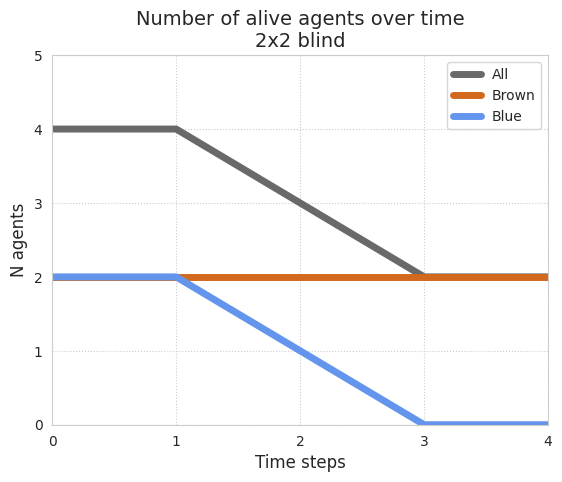

In [137]:
plot_agents(model)

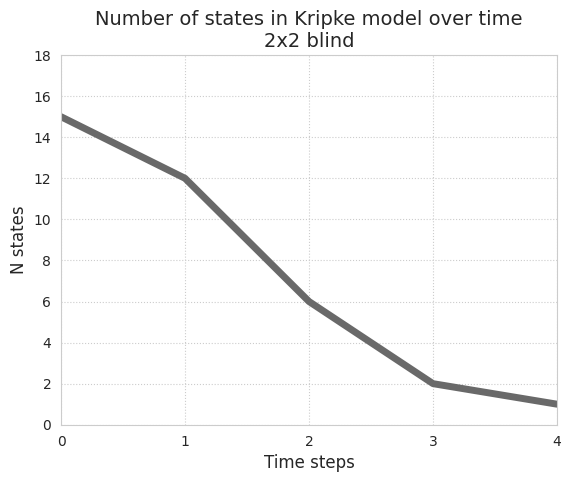

In [138]:
plot_states(model)

In [139]:
# Delete old model before re-running
del model